In [1]:
import torch
from nets import CTNet, GAPNet

import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from transform_features import FeatureDegree
from torch_geometric.datasets import TUDataset
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import DenseGraphConv
from torch_geometric.utils import to_dense_batch, to_dense_adj
from CT_layer import dense_CT_rewiring
from GAP_layer import *
from MinCut_Layer import dense_mincut_pool
from sklearn.model_selection import train_test_split

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## Import dataset

In [3]:
"""dataset = TUDataset(root='data_colab/TUDataset',name="REDDIT-BINARY", pre_transform=FeatureDegree(), use_node_attr=True)
BATCH_SIZE = 64
"""

dataset = TUDataset(root='data/TUDataset',name="COLLAB", pre_transform=FeatureDegree(), use_node_attr=True)
BATCH_SIZE = 64
num_of_centers = 75

print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}, {dataset.num_node_features}, {dataset.num_node_attributes}')
print(f'Number of classes: {dataset.num_classes}')
#dataset = dataset.shuffle()
print()
datum = dataset[0]  # Get the first graph object.
print(datum)
print('=============================================================')
# Gather some statistics about the first graph.
print(f'Number of nodes: {datum.num_nodes}')
print(f'Number of edges: {datum.num_edges}')
print(f'Average node degree: {datum.num_edges / datum.num_nodes:.2f}')
print(f'Has isolated nodes: {datum.has_isolated_nodes()}')
print(f'Has self-loops: {datum.has_self_loops()}')
print(f'Is undirected: {datum.is_undirected()}')


print(dataset)

Dataset: COLLAB(5000):
Number of graphs: 5000
Number of features: 1, 1, 1
Number of classes: 3

Data(edge_index=[2, 1980], y=[1], x=[45, 1], num_nodes=45)
Number of nodes: 45
Number of edges: 1980
Average node degree: 44.00
Has isolated nodes: False
Has self-loops: False
Is undirected: True
COLLAB(5000)


## Balanced train and test split

In [4]:
#Same order than training
train_indices, test_indices = train_test_split(list(range(len(dataset.data.y))), test_size=0.2, stratify=dataset.data.y,
                                random_state=12345, shuffle=True)
train_indices.extend(test_indices)
new_order = train_indices
dataset = dataset[test_indices]
loader =  DataLoader(dataset, batch_size=64, shuffle=False)

## Modified model to obtain the new edge_index

In [502]:

class CTNet_toy(torch.nn.Module):
    def __init__(self, in_channels, out_channels, k_centers, hidden_channels=32, EPS=1e-15):
        super(CTNet_toy, self).__init__()
        self.EPS=EPS
        # GCN Layer - MLP - Dense GCN Layer
        #self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv1 = DenseGraphConv(hidden_channels, hidden_channels)
        self.conv2 = DenseGraphConv(hidden_channels, hidden_channels)
        
        # The degree of the node belonging to any of the centers
        num_of_centers1 =  k_centers # k1 #order of number of nodes
        self.pool1 = Linear(hidden_channels, num_of_centers1)
        num_of_centers2 =  16 # k2 #mincut 
        self.pool2 = Linear(hidden_channels, num_of_centers2) 

        # MLPs towards out 
        self.lin1 = Linear(in_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, hidden_channels)
        self.lin3 = Linear(hidden_channels, out_channels)
        self.new_adj = torch.zeros(0)
        self.new_nodes = torch.zeros(0)
        self.new_mincut = torch.zeros(0)
    def forward(self, x, edge_index, batch):    # x torch.Size([N, N]),  data.batch  torch.Size([661])  
        # Make all adjacencies of size NxN 
        adj = to_dense_adj(edge_index, batch)   # adj torch.Size(B, N, N])
        #print("adj_size", adj.size())
        #print("adj",adj)

        # Make all x_i of size N=MAX(N1,...,N20), e.g. N=40: 
        #print("x size", x.size())
        x, mask = to_dense_batch(x, batch)      # x torch.Size([20, N, 32]) ; mask torch.Size([20, N]) batch_size=20
        #print("x size", x.size())

        x = self.lin1(x)
        # First mincut pool for computing Fiedler adn rewire 
        s1  = self.pool1(x)
        #s1 = torch.variable()#s1 torch.Size([20, N, k1=2)
        #s1 = Variable(torch.randn(D_in, H).type(float16), requires_grad=True)
        #print("s 1st pool",s1)
        #print("s 1st pool size", s1.size())

        if torch.isnan(adj).any():
          print("adj nan")
        if torch.isnan(x).any():
          print("x nan")
        
        # CT REWIRING
        adj, CT_loss, ortho_loss1 = dense_CT_rewiring(x, adj, s1, mask, EPS = self.EPS) # out: x torch.Size([20, N, F'=32]),  adj torch.Size([20, N, N])
        self.new_adj = adj.clone()
        #print("CT_loss, ortho_loss1", CT_loss, ortho_loss1)
        #print("x",x)
        #print("adj",adj)
        #print("x and adj sizes", x.size(), adj.size())
        #adj = torch.softmax(adj, dim=-1)
        #print("adj softmaxed", adj)

        # CONV1: Now on x and rewired adj: 
        x = self.conv1(x, adj) #out: x torch.Size([20, N, F'=32])
        #print("x_1 ", x)
        #print("x_1 size", x.size())
        
        # MLP of k=16 outputs s
        #print("adj_size", adj.size())
        s2 = self.pool2(x) # s torch.Size([20, N, k])
        #print("s 2nd pool", s2)
        #print("s 2nd pool size", s2.size())
        #adj = torch.softmax(adj, dim=-1)
        
        
        # MINCUT_POOL
        # Call to dense_cut_mincut_pool to get coarsened x, adj and the losses: k=16
        #x, adj, mincut_loss1, ortho_loss1 = dense_mincut_rewiring(x, adj, s1, mask) # x torch.Size([20, k=16, F'=32]),  adj torch.Size([20, k2=16, k2=16])
        x, adj, mincut_loss2, ortho_loss2 = dense_mincut_pool(x, adj, s2, mask, EPS=self.EPS) # out x torch.Size([20, k=16, F'=32]),  adj torch.Size([20, k2=16, k2=16])
        self.new_nodes = x.clone()
        self.new_mincut = adj.clone()
        #print("lossses2",mincut_loss2, ortho_loss2)
        #print("mincut pool x", x)
        #print("mincut pool adj", adj)
        #print("mincut pool x size", x.size())
        #print("mincut pool adj size", adj.size()) # Some nan in adjacency: maybe comming from the rewiring-> dissapear after clipping
        

        # CONV2: Now on coarsened x and adj: 
        x = self.conv2(x, adj) #out x torch.Size([20, 16, 32])
        #print("x_2", x)
        #print("x_2 size", x.size())
        
        # Readout for each of the 20 graphs
        #x = x.mean(dim=1) # x torch.Size([20, 32])
        x = x.sum(dim=1) # x torch.Size([20, 32])
        #print("mean x_2 size", x.size())
        
        # Final MLP for graph classification: hidden channels = 32
        x = F.relu(self.lin2(x)) # x torch.Size([20, 32])
        #print("final x1 size", x.size())
        x = self.lin3(x) #x torch.Size([20, 2])
        #print("final x2 size", x.size())
        CT_loss = CT_loss + ortho_loss1
        mincut_loss = mincut_loss2 + ortho_loss2
        #print("x", x)
        return F.log_softmax(x, dim=-1), CT_loss, mincut_loss

## Loading preentrained model with our modifications

In [503]:
model_to_import = "trained_models/COLLAB_CTNet_17_05_22__08_56_iter0.pth"
model =  CTNet_toy(dataset.num_features, dataset.num_classes,num_of_centers).to(device)
model.load_state_dict(torch.load(model_to_import, map_location=torch.device(device)))
model.eval()

CTNet_toy(
  (conv1): DenseGraphConv(32, 32)
  (conv2): DenseGraphConv(32, 32)
  (pool1): Linear(in_features=32, out_features=75, bias=True)
  (pool2): Linear(in_features=32, out_features=16, bias=True)
  (lin1): Linear(in_features=1, out_features=32, bias=True)
  (lin2): Linear(in_features=32, out_features=32, bias=True)
  (lin3): Linear(in_features=32, out_features=3, bias=True)
)

## Test it

In [504]:
@torch.no_grad()
def test(loader):
    model.eval()
    correct = 0
    for data in loader:
        data = data.to(device)
        pred, mc_loss, o_loss = model(data.x, data.edge_index, data.batch)
        #print(next(model.parameters()).device)
        #print(data.x.device)
        loss = F.nll_loss(pred, data.y.view(-1)) + mc_loss + o_loss
        correct += pred.max(dim=1)[1].eq(data.y.view(-1)).sum().item()

    return loss, correct / len(loader.dataset)
loss, acc = test(loader)

In [505]:
print(loss, acc)

tensor(9.9579) 0.7208121827411168


## Getting a sample from dataset

In [506]:
# 15,20,25,27,31,38,44 works good
#interesting 28
loader =  DataLoader(dataset[15:], batch_size=1, shuffle=False)
grafo_init= next(iter(loader))
grafo_falso = next(iter(loader)).clone()
#grafo_init.batch = torch.tensor(1).unsqueeze(0)
#print(grafo_init.batch.shape)
grafo_init

DataBatch(edge_index=[2, 454], y=[1], x=[32, 1], num_nodes=32, batch=[32], ptr=[2])

DataBatch(edge_index=[2, 454], y=[1], x=[32, 1], num_nodes=32, batch=[32], ptr=[2])
32
<Layout with 32 vertices and 3 dimensions>
dict_values([2, 2, 0, 0, 0, 1, 0, 1, 1, 2, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0])


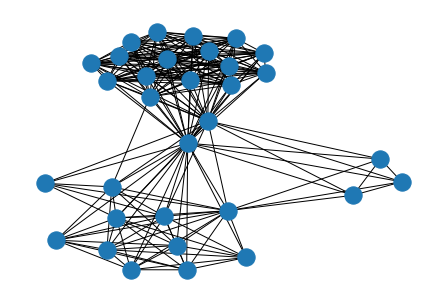

In [510]:
import networkx as nx
from torch_geometric.utils import *
from community import community_louvain
print(grafo_init)
A = to_networkx(grafo_init, to_undirected=True)
l=[]
for a in A.nodes:
    l.append(a)
ed= []
for e in A.edges:
    ed.append(e)
import igraph as ig
import chart_studio.plotly
Edges= ed
G=ig.Graph(Edges, directed=False)
labels= l
#groups = A.node_attr_dict_factory
N = len(A.nodes)
print(N)
layt=G.layout('kk', dim=3)
print(layt)
Xn=[layt[k][0] for k in range(N)]# x-coordinates of nodes
Yn=[layt[k][1] for k in range(N)]# y-coordinates
Zn=[layt[k][2] for k in range(N)]# z-coordinates
Xe=[]
Ye=[]
Ze=[]
#print(Edges)
for e in Edges:
    Xe+=[layt[e[0]][0],layt[e[1]][0], None]# x-coordinates of edge ends
    Ye+=[layt[e[0]][1],layt[e[1]][1], None]
    Ze+=[layt[e[0]][2],layt[e[1]][2], None]
nx.draw(A)
node_adjacencies = []
node_text = []
#Comunity nodes
partition = community_louvain.best_partition(A, random_state=1234)
for node, adjacencies in enumerate(A.adjacency()):
    node_adjacencies.append(partition[node])
    #node_text.append('# of connections: '+str(len(adjacencies[1])))
print(partition.values())

In [511]:
from chart_studio import plotly
import plotly.graph_objs as go

trace1=go.Scatter3d(x=Xe,
               y=Ye,
               z=Ze,
               mode='lines',
               line=dict(color='rgb(125,125,125)', width=1),
               hoverinfo='none'
               )

trace2=go.Scatter3d(x=Xn,
               y=Yn,
               z=Zn,
               mode='markers',
               name='actors',
               marker=dict(symbol='circle',
                             size=6,
                             #color='#ff7f0e',
                             colorscale='Viridis',
                             line=dict(color='rgb(50,50,50)', width=0.5)
                             ),
               text=labels,
               hoverinfo='text'
               )
trace2.marker.color = node_adjacencies
axis=dict(showbackground=False,
          showline=False,
          zeroline=False,
          showgrid=False,
          showticklabels=False,
          title=''
          )

layout = go.Layout(
         title="Original",
         width=1000,
         height=1000,
         showlegend=False,
         scene=dict(
             xaxis=dict(axis),
             yaxis=dict(axis),
             zaxis=dict(axis),
        ),
     margin=dict(
        t=100
    ),
    hovermode='closest'    )

In [512]:
import pandas as pd
import numpy as np
%matplotlib inline
import plotly.graph_objs as go
from  plotly.offline import plot
import chart_studio.plotly as py
import cufflinks as cf
cf.go_offline()
from plotly.offline import download_plotlyjs, init_notebook_mode, plot,iplot
init_notebook_mode(connected='true')
data=[trace1, trace2]
fig=go.Figure(data=data, layout=layout)

iplot(fig, filename='Les-Miserables')

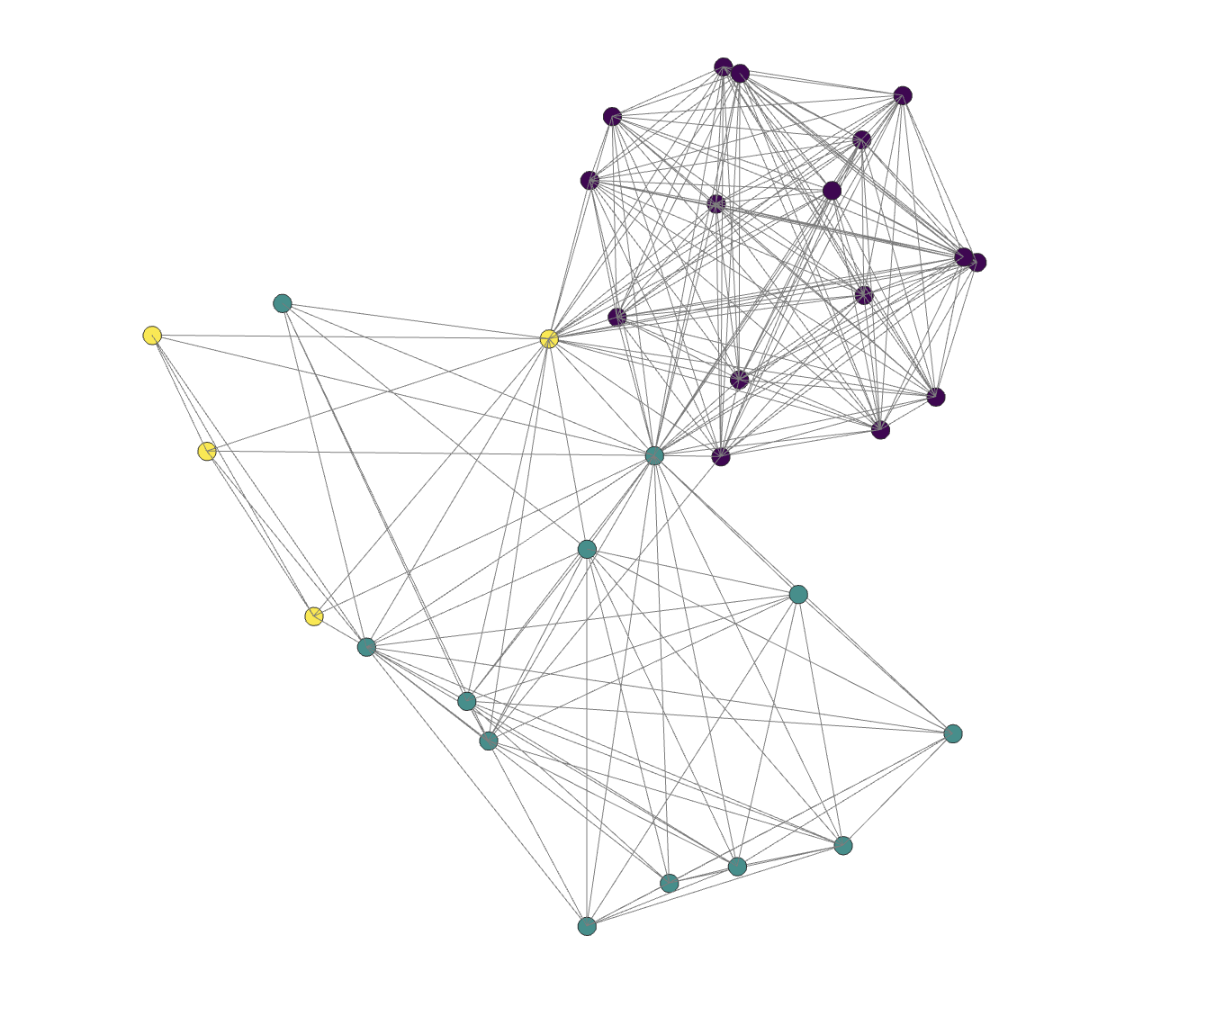

In [514]:
#Checking the model with the selected sample
correct = 0
print(grafo_init)
pred, mc_loss, o_loss = model(grafo_init.x, grafo_init.edge_index, grafo_init.batch)
loss = F.nll_loss(pred, grafo_init.y.view(-1)) + mc_loss + o_loss
correct += pred.max(dim=1)[1].eq(grafo_init.y.view(-1)).sum().item()
print("Accuracy: ",(correct/1)*100)

print("Original number of edges: ",grafo_init.edge_index.size(1))
new_edges=(model.new_adj.squeeze(0).transpose(0,1).nonzero())
print("Edges after the CT_rewring: ",new_edges.size(0))
print("NUevos nodos",model.new_nodes.squeeze(0).shape)
new_nodes = model.new_nodes.squeeze(0)
new_mincut = (model.new_nodes.squeeze(0)>(model.new_nodes.squeeze(0)).mean()).nonzero().transpose(0,1)
print("Nuevos nodos despues del mincut",model.new_mincut.squeeze(0).shape)

DataBatch(edge_index=[2, 454], y=[1], x=[32, 1], num_nodes=32, batch=[32], ptr=[2])
Accuracy:  100.0
Original number of edges:  454
Edges after the CT_rewring:  224
NUevos nodos torch.Size([16, 32])
Nuevos nodos despues del mincut torch.Size([16, 16])


### Stats about the new adj

In [524]:
#print("Max in every row: ",model.new_adj.squeeze(0).max(0)[0].tolist())
print(model.new_adj.squeeze(0).mean())
print(torch.std(model.new_adj.squeeze(0)))

tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0005, grad_fn=<StdBackward0>)


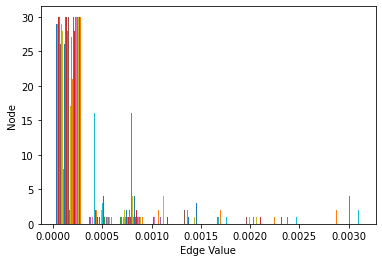

In [525]:
import matplotlib.pyplot as plt
plt.hist(model.new_adj.squeeze(0).detach().numpy())
plt.ylabel('Node')
plt.xlabel('Edge Value')
plt.show()

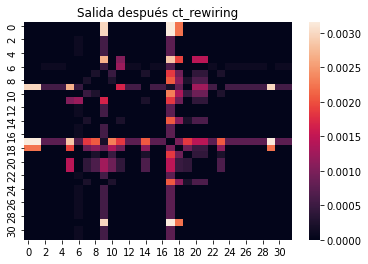

In [527]:
import seaborn as sn
sn.heatmap(model.new_adj.squeeze(0).detach().numpy(), annot=False, fmt='g')
plt.title("Salida después ct_rewiring")
plt.show()

<class 'torch.Tensor'>
DataBatch(edge_index=[2, 454], y=[1], x=[32, 1], num_nodes=32, batch=[32], ptr=[2])
DataBatch(edge_index=[2, 454], y=[1], x=[32, 1], num_nodes=32, batch=[32], ptr=[2])
224
Graph with 32 nodes and 227 edges
Graph with 32 nodes and 227 edges


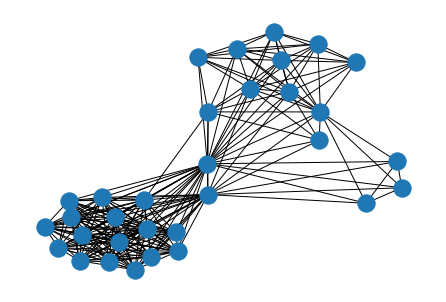

In [531]:
import networkx as nx
from torch_geometric.utils import *
#!pip install colorpy
from mycolorpy import colorlist as mcp
print(type(grafo_init.edge_index))
print(grafo_init)
print(grafo_init)
A = to_networkx(grafo_init, to_undirected=True)
#A.edges = kk
l=[]
for a in A.nodes:
    l.append(a)
ed= []
for e in A.edges:
    ed.append(e)
new_Edges=[]
for ne in new_edges:
    new_Edges.append(ne)
import igraph as ig
import chart_studio.plotly
Edges= ed
G=ig.Graph(Edges, directed=False)
labels= l
#groups = A.node_attr_dict_factory
N = len(A.nodes)
layt=G.layout('kk', dim=3)
#print(layt)
Xn=[layt[k][0] for k in range(N)]# x-coordinates of nodes
Yn=[layt[k][1] for k in range(N)]# y-coordinates
Zn=[layt[k][2] for k in range(N)]# z-coordinates
Xe=[]
Ye=[]
Ze=[]
for e in Edges:
    #print(e)
    Xe+=[layt[e[0]][0],layt[e[1]][0], None]# x-coordinates of edge ends
    Ye+=[layt[e[0]][1],layt[e[1]][1], None]
    Ze+=[layt[e[0]][2],layt[e[1]][2], None]
#EN ESTE PASO RECALCO LOS EDGES NUEVOS
Xnew_edges=[]
Ynew_edges=[]
Znew_edges=[]
print(len(new_Edges))
for e in new_Edges:
    #print(e)
    Xnew_edges+=[layt[e[0]][0],layt[e[1]][0], None]# x-coordinates of edge ends
    Ynew_edges+=[layt[e[0]][1],layt[e[1]][1], None]
    Znew_edges+=[layt[e[0]][2],layt[e[1]][2], None]
nx.draw(A)
node_adjacencies = []
node_text = []
print(A)

C = A
print(C)
C.edge_index = new_edges
partition = community_louvain.best_partition(C, random_state=1234)
for node, adjacencies in enumerate(C.adjacency()):
    node_adjacencies.append(partition[node])
    #node_text.append('# of connections: '+str(len(adjacencies[1])))
#Color creation

edge_importance = []
edge_importance.append(0)
importance = model.new_adj.squeeze(0).detach().numpy()
#vColor =mcp.gen_color_normalized(cmap="seismic",data_arr=importance)
for edge, conections in enumerate(new_Edges):
    edge_importance.append(importance[conections[0],[conections[1]]].item()+1000)
#print(edge_importance)
final_color_edge = []
vColor =mcp.gen_color_normalized(cmap="seismic",data_arr=edge_importance)
for edge, conections in enumerate(new_Edges):
    final_color_edge.append(vColor[edge])

In [534]:
from chart_studio import plotly
import plotly.graph_objs as go

trace1=go.Scatter3d(x=Xe,
               y=Ye,
               z=Ze,
               mode='lines',
               line=dict(color='rgb(0,0,0)', width=1),
               hoverinfo='none'
               )

trace2=go.Scatter3d(x=Xn,
               y=Yn,
               z=Zn,
               mode='markers',
               name='actors',
               marker=dict(symbol='circle',
                             size=6,
                             color='#ff7f0e',
                             colorscale='Viridis',
                             line=dict(color='rgb(50,50,50)', width=0.5)
                             ),
               text=labels,
               hoverinfo='text'
               )
trace2.marker.color = node_adjacencies
#Lo mismo de antes, estas las pinto de negro y las antiguas de blanco (una pequeña chapuza)
# Vale no, abajo explico como hacerlo sin chapuza
trace3=go.Scatter3d(x=Xnew_edges,
               y=Ynew_edges,
               z=Znew_edges,
               mode='lines',
               line=dict(color=vColor, width=2),
               marker=dict(size=3,color=vColor,colorscale='Jet',showscale=True),
               hoverinfo='none'
               )
trace3.line.color = final_color_edge
axis=dict(showbackground=False,
          showline=False,
          zeroline=False,
          showgrid=False,
          showticklabels=False,
          title=''
          )

layout = go.Layout(
         title="CT_Rewiring",
         width=1000,
         height=1000,
         showlegend=False,
         scene=dict(
             xaxis=dict(axis),
             yaxis=dict(axis),
             zaxis=dict(axis),
        ),
     margin=dict(
        t=100
    ),
    hovermode='closest',    )

In [535]:
import pandas as pd
import numpy as np
%matplotlib inline
import plotly.graph_objs as go
from  plotly.offline import plot
import chart_studio.plotly as py
import cufflinks as cf
cf.go_offline()
from plotly.offline import download_plotlyjs, init_notebook_mode, plot,iplot
init_notebook_mode(connected='true')
#Si en data no pongo trace1(que son los antiguos edges) no me los imprime y no es una chapuza
data=[trace2,trace3]
fig=go.Figure(data=data, layout=layout)

iplot(fig, filename='Les-Miserables')